<a href="https://colab.research.google.com/github/youssefhanighazal10/Face-Recognition/blob/main/Final_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing dataset from kaggle**

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kasikrit/att-database-of-faces
! unzip att-database-of-faces

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier

**Functions**

In [ ]:
def Split_data (data,label):
  X_train = np.empty((0,10304))
  Y_train = np.empty((0,1))
  X_test = np.empty((0,10304))
  Y_test = np.empty((0,1))
  for i in range(0,len(data)):
    if i%2==0:
      X_test = np.append(X_test,np.array([data[i]]),axis = 0)
      Y_test = np.append(Y_test,label[i])  
    if i%2==1:
      X_train = np.append(X_train,np.array([data[i]]),axis = 0)
      Y_train = np.append(Y_train,label[i]) 
  return X_train,X_test,Y_train,Y_test

In [ ]:
def PCA(X_train,X_test):
  mean = np.mean(X_train,axis=0)
  z = X_train - np.transpose(mean) # Center the data
  covariance = np.cov(np.transpose(z),bias=True)
  eigen_values,eigen_vectors = np.linalg.eigh(covariance)
  # Sorting in decreasing order
  idx = eigen_values.argsort()[::-1]   
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]
  eigen_values = np.diag(eigen_values)
  # Allowed Variance
  trace = np.trace(eigen_values)
  alpha_values = [0.8,0.85,0.9,0.95]
  alpha = 0
  i = 0
  while alpha <= alpha_values[0]:
    alpha = alpha + eigen_values[i][i]/trace
    i = i + 1 
  # Projection Matrix
  U = eigen_vectors[:,0:i]
  # Project the data
  X_train_pca = np.dot(X_train,U)
  X_test_pca = np.dot(X_test,U)
  
  return X_train_pca,X_test_pca

In [ ]:
def Split_lda(data,n_classes,class_samples):
  # Split Data into Classes
  classes = np.empty((0,class_samples,10304))
  for i in range(0,len(data),class_samples):
    classes = np.append(classes,np.array([data[i:i+class_samples]]),axis = 0)
  # Split classes into training and testing
  X_train_lda = np.empty((0,int(class_samples/2),10304))
  X_test_lda = np.empty((0,int(class_samples/2),10304))
  for i in range(0,n_classes):
    x_train = np.empty((0,10304))
    x_test = np.empty((0,10304))
    for j in range(0,class_samples):
      if j%2==0:
        x_test = np.append(x_test,np.array([classes[i,j]]),axis = 0) 
      if j%2==1:
        x_train = np.append(x_train,np.array([classes[i,j]]),axis = 0)
    X_train_lda = np.append(X_train_lda,np.array([x_train]),axis = 0)
    X_test_lda = np.append(X_test_lda,np.array([x_test]),axis = 0) 
  return X_train_lda,X_test_lda


In [ ]:
def LDA(data,n_classes,class_samples):
  # Split Data
  X_train,X_test = Split_lda(data,n_classes,class_samples)
  # Compute Mean
  mean = np.empty((0,10304))
  for i in range(0,n_classes):
    m=np.mean(X_train[i],axis = 0)
    mean = np.append(mean,np.array([m]),axis = 0)
  overall_mean =  np.mean(mean,axis=0)
  # Compute between class scatter matrix
  Sb = np.empty((10304,10304))
  mu = np.empty((0))
  for i in range(0,n_classes):
    mu = (mean[i]-overall_mean).reshape(10304,1)
    Sb += 10*np.dot(mu,np.transpose(mu))   
  # Centering Data
  z = np.empty((0,int(class_samples/2),10304))
  for i in range(0,n_classes):
    z = np.append(z,np.array([X_train[i]-mean[i]]),axis = 0)
  # Compute Within class scatter matrix
  Sw = np.empty((10304,10304))
  for i in range(0,n_classes):
    Sw += np.dot(np.transpose(z[i]),z[i])
  # Matrix for Eigen decomposition
  LDA = np.dot(np.linalg.inv(Sw),Sb)
  eigen_values,eigen_vectors = np.linalg.eigh(LDA)
  # Sorting in decreasing order
  idx = eigen_values.argsort()[::-1]   
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]
  eigen_values = np.diag(eigen_values)
  # Reducing eigen vector to 39 vectors
  eigen_vectors_reduced = eigen_vectors[:,0:39]
  # Project Data
  X_train_lda_projected = np.dot(X_train,eigen_vectors_reduced)
  X_test_lda_projected = np.dot(X_test,eigen_vectors_reduced)
  # Reshape
  X_train_lda_projected = X_train_lda_projected.reshape(int(n_classes*class_samples/2),39)
  X_test_lda_projected = X_test_lda_projected.reshape(int(n_classes*class_samples/2),39)
  
  return  X_train_lda_projected,X_test_lda_projected

In [ ]:
def Classification(X_train,Y_train,X_test,Y_test):
  k = np.array([1,3,5,7])
  accuracy = np.array([])
  for i in range(0,4):
    neigh = KNeighborsClassifier(n_neighbors=k[i])
    neigh.fit(X_train,Y_train)
    print(neigh.predict(X_test))
    accuracy = np.append(accuracy,neigh.score(X_test, Y_test))
  plt.plot(k,accuracy)
  return accuracy

**Main**

In [ ]:
faces = np.empty((0,10304))
for i in range(1,41):
  for j in range(1,11):
    face = cv2.imread(f's{i}/{j}.pgm',0) 
    face = face.flatten()
    faces = np.append(faces,np.array([face]),axis=0)
    
y_f = np.empty((0,1))
for i in range(1,41):
  for j in range(1,11):
    y_f = np.append(y_f,i)

**PCA Faces**

In [ ]:
X_train_f,X_test_f,Y_train_f,Y_test_f = Split_data(faces,y_f)
X_train_pca_f,X_test_pca_f = PCA(X_train_f,X_test_f)
Classification(X_train_pca_f,Y_train_f,X_test_pca_f,Y_test_f) 

[16.  2.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 38. 11. 11. 11. 11.
 11. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 15. 15.
 15. 15. 15. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 36. 20. 20.  3. 20. 20. 21. 21. 21. 21. 21. 22. 22. 22.
 22. 22. 23. 23. 23. 23. 23. 24. 24. 24. 24. 24. 25. 25. 25. 25. 25. 26.
 26. 26. 26. 26. 27. 27. 27. 27. 27. 28. 28. 28. 28. 28. 29. 29. 29. 29.
 29. 30. 30. 30. 30. 30. 31. 31. 31. 21. 31. 32. 32. 32.  2. 32. 33. 33.
 33. 33. 33. 34. 34. 34. 34. 34. 40. 15. 35. 35. 35.  7. 36.  7. 36. 36.
 37. 37. 37. 37. 37. 38. 38. 38. 38. 38. 39. 39. 39. 39. 39. 40. 40.  5.
  5.  5.]
[16.  2.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3. 25.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 

array([0.93 , 0.855, 0.805, 0.78 ])

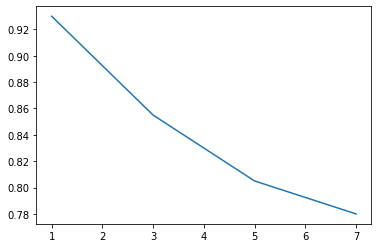

**LDA Faces**

In [ ]:
X_train_lda_f,X_test_lda_f = LDA(faces,40,10)

[16.  2.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 38. 11. 11. 11. 11.
 11. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 15. 15.
 15. 15. 15. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 11. 20. 20.  3. 20. 20. 21. 21. 21. 21. 21. 22. 22. 22.
 22. 22. 23. 23. 23. 23. 23. 24. 24. 24. 24. 24. 25. 25. 25. 25. 25. 26.
 26. 26. 26. 26. 27. 27. 27. 27. 27. 28. 28. 28. 28. 28. 29. 29. 29. 29.
 39. 30. 30. 30. 30. 30. 31. 31. 31. 30. 31. 32. 32. 32. 32. 32. 33. 33.
 33. 33. 33. 34. 34. 34. 34. 34. 40. 15. 35. 35. 13.  7. 36.  7. 36. 36.
 37. 37. 37. 37. 37. 38. 38. 38. 38. 23. 39. 39. 39. 39. 39. 40. 40. 40.
 40.  5.]
[16.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3. 25.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 

array([0.93 , 0.84 , 0.795, 0.765])

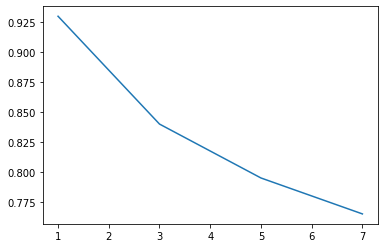

In [ ]:
Classification(X_train_lda_f,Y_train_f,X_test_lda_f,Y_test_f)

**Non Faces VS Faces** 400

In [ ]:
non_faces = np.empty((0,10304))
for i in range(1,401):
  img = cv2.imread(f'Non_faces_final/nf ({i}).jpg',0)
  img = cv2.resize(img, (92,112))
  img = img.flatten()
  non_faces = np.append(non_faces,np.array([img]),axis = 0)

y = np.empty(0)
for i in range (0,400):
  y = np.append(y,1)
for i in range (0,400):
  y = np.append(y,0)

# Data with 400 Non-faces vs 400 Faces
data_new = np.vstack((faces,non_faces))

# Data with 200 Non-faces vs 400 Faces
data_new_600 = np.vstack((faces,non_faces[0:200]))
y_600 = y[0:600]


In [ ]:
X_train_nf,X_test_nf,Y_train_nf,Y_test_nf = Split_data(data_new,y)

**PCA Non Faces** 400

In [ ]:
X_train_pca_nf,X_test_pca_nf = PCA(X_train_nf,X_test_nf) 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.

array([0.91  , 0.89  , 0.8825, 0.8725])

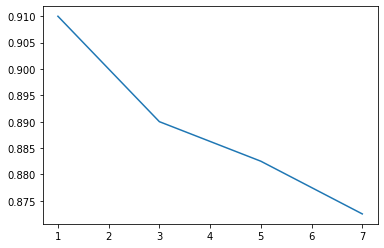

In [ ]:
Classification(X_train_pca_nf,Y_train_nf,X_test_pca_nf,Y_test_nf)

**LDA Non Faces** 400

In [ ]:
X_train_lda_nf , X_test_lda_nf = LDA(data_new,2,400)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.

array([0.9275, 0.905 , 0.9   , 0.8925])

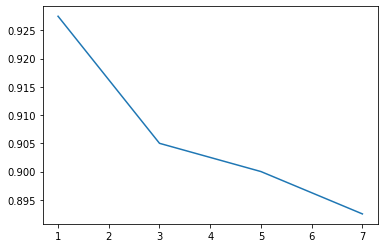

In [ ]:
Classification(X_train_lda_nf,Y_train_nf,X_test_lda_nf,Y_test_nf)

**Faces vs Non-Faces** 200

**PCA**

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

array([0.94      , 0.91666667, 0.89      , 0.87      ])

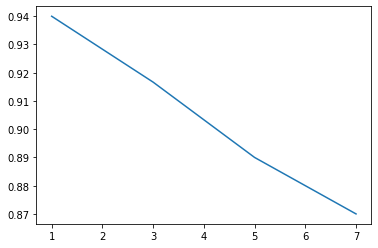

In [ ]:
X_train_600,X_test_600,Y_train_600,Y_test_600 = Split_data(data_new_600,y_600)
X_train_pca_600,X_test_pca_600 = PCA(X_train_600,X_test_600)
Classification(X_train_pca_600,Y_train_600,X_test_pca_600,Y_test_600)

**LDA**

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

array([0.96      , 0.94333333, 0.93333333, 0.92333333])

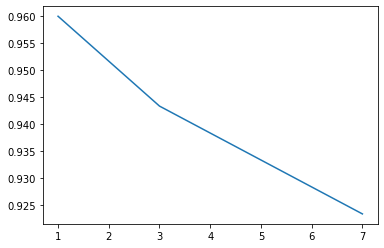

In [ ]:
# Split Data into Classes
class_faces = data_new_600[0:400]
class_non_faces = data_new_600[400:600]

X_train_lda_600_f = X_train_600[0:200]
X_train_lda_600_nf = X_train_600[200:300]
X_test_lda_600_f = X_test_600[0:200]
X_test_lda_600_nf = X_test_600[200:300]

# Compute Mean
mean = np.empty((0,10304))
m1 = np.mean(X_train_lda_600_f,axis = 0).reshape(10304,1)
m2 = np.mean(X_train_lda_600_nf,axis = 0).reshape(10304,1)
# Compute between class scatter matrix
Sb = np.dot((m1-m2),(m1-m2).T)
z1 =  X_train_lda_600_f - m1.reshape(10304)
z2 =  X_train_lda_600_nf - m2.reshape(10304)
S1 = np.dot(z1.T,z1)
S2 = np.dot(z2.T,z2)
S = S1 + S2
LDA = np.dot(np.linalg.inv(S),Sb)
eigen_values,eigen_vectors = np.linalg.eigh(LDA)
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]
eigen_values = np.diag(eigen_values)
eigen_vectors_reduced = eigen_vectors[:,0:39]
X_train_lda_600_projected = np.dot(X_train_600,eigen_vectors_reduced)
X_test_lda_600_projected = np.dot(X_test_600,eigen_vectors_reduced)
Classification(X_train_lda_600_projected,Y_train_600,X_test_lda_600_projected,Y_test_600)
